[ 2.73755399  0.01142786]
8.87133888344e+16


<IPython.core.display.Javascript object>


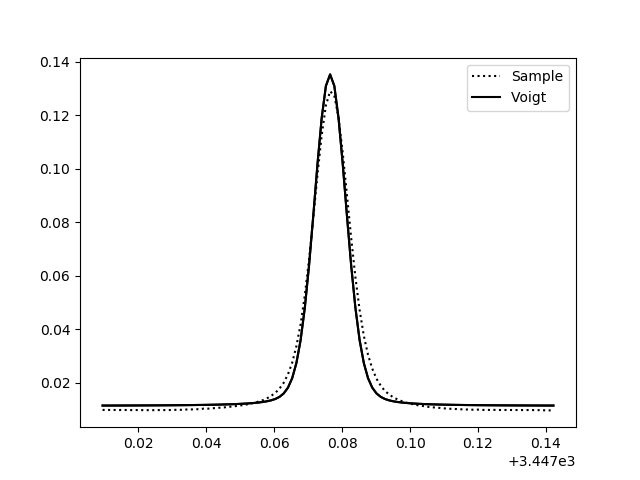

In [71]:
%matplotlib notebook
import numpy as np
from scipy.special import wofz
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

""" File Import """
samp_file = r"C:\Users\winiberg\Documents\Work\JPL\ALS - Nitrate TEMP\Abs_Spec_test.txt"
temp_data = np.genfromtxt(samp_file, dtype='f8')
x_data, samp_data = np.hsplit(temp_data,2)

#Flatten arrays so that fitting function works!
x_data = x_data.flatten()
samp_data = samp_data.flatten()


""" Constants """
c = 2.998e10 #Speed of light, cm s-1
Na = 6.02214129e23 #Avogadro's number, mol-1
kb = 1.38064852e-16 # Boltzman Constant, cm2 g s-1 K-1
R = 8314000 # Gas Constant
Temp = 298 # Temp, K
p = 10 # Pressure, Torr
PL = 10 # path length,  cm
#p_self = 15 # Torr - just for testing! 
#CONC = 1e16 # Initial guess of concentration, cm-3


""" Species/Line params """
#Species 1 - H2O
M_S1 = 18.01528 # g mol-1
##Line 1
v_S1L1 = 3447.076453 # cm-1
g_air_S1L1 = 0.0728 # air broadening
g_self_S1L1 = 0.0728 # self broadening
S_S1L1 = 1.771e-21 # Line strength, (molecule-1 cm2)/(cm-1)



def p_to_Conc(p, T):
    """ Returns the concentration based on a given pressure (Torr) and temperature (K) """
    return ((p*133.322)/(R*T))*Na

def G_HWHM(v_cent, T, M):
    """ Return Gaussian HWHM alpha based on line params """
    return (v_cent/c) * np.sqrt((2*Na*kb*T*np.log(2))/M)

def L_HWHM(g_air, g_self, p, p_self):
    """ Return Loren HWHM alpha based on line params """
    p_self = p_self * 0.00132
    p = p * 0.00132
    return g_air*(p-p_self)+g_self*p_self

def V_func(x, p_self, offset):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.
    """
    
    sigma = G_HWHM(v_S1L1, Temp, M_S1) / np.sqrt(2 * np.log(2))
    gamma = L_HWHM(g_air_S1L1, g_self_S1L1, p, p_self)
    
    V_f = ((((np.real(wofz(((x-v_S1L1) + 1j*gamma)/sigma/np.sqrt(2))) / sigma \
              /np.sqrt(2*np.pi))*S_S1L1)*PL*p_to_Conc(p_self,Temp))+offset)
    
    return V_f

popt, pconv = curve_fit(V_func,x_data,samp_data)

print(popt)
Conc1 = popt[0]
Offset = popt[1]
print(p_to_Conc(Conc1,Temp))

plt.plot(x_data, samp_data, ls=':', c='k', label='Sample')
plt.plot(x_data, V_func(x_data, *popt), c='k', label='Voigt')
plt.legend()
plt.show()

plt.plot(x_data, V_func(x_data, *popt), c='k', label='Voigt')
plt.legend()
plt.show()